In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import datetime
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from datetime import datetime
from random import sample
import torch
from torch import nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from time import time

In [2]:
df = pd.read_csv("octroi_RCI.csv",sep=';')

# Data discovery

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8457 entries, 0 to 8456
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ANC_EMPLOI      8457 non-null   int64  
 1   SITUATION_FAM   8457 non-null   int64  
 2   MODE_LOGT       8349 non-null   float64
 3   AGE_VEH         2454 non-null   float64
 4   VN_VO           8457 non-null   object 
 5   MARQUE          8457 non-null   object 
 6   PRIX_VEH        8457 non-null   object 
 7   MT_APPORT       8457 non-null   object 
 8   MT_FINANCE      8457 non-null   object 
 9   MT_MENS         8457 non-null   object 
 10  VR_BALLON       3219 non-null   object 
 11  DUREE_CONTRAT   8457 non-null   int64  
 12  MT_PREST        7177 non-null   object 
 13  MT_ASSUR        1702 non-null   object 
 14  mois_gestion    8457 non-null   object 
 15  age_cli         8457 non-null   int64  
 16  anciennete_rci  1186 non-null   float64
 17  pc_appo         8457 non-null   i

In [5]:
df.head()

,ANC_EMPLOI,SITUATION_FAM,MODE_LOGT,AGE_VEH,VN_VO,MARQUE,PRIX_VEH,MT_APPORT,MT_FINANCE,MT_MENS,VR_BALLON,DUREE_CONTRAT,MT_PREST,MT_ASSUR,mois_gestion,age_cli,anciennete_rci,pc_appo,def12_31
0,65,2,1.0,NaN,VN,REN,"19584,65",0,"19584,65","95,01","19584,63",6,NaN,NaN,01/03/2015,28,1.0,0,0
1,563,11,2.0,28.0,VO,REN,16995,2123,14872,"312,34",NaN,60,150,NaN,01/06/2014,64,3.0,12,0
2,107,2,2.0,16.0,VO,REN,19950,3869,16081,"329,93",NaN,60,150,NaN,01/08/2015,51,3.0,19,0
3,143,2,2.0,10.0,VO,REN,17500,"7143,5","10356,5","217,51",NaN,60,150,NaN,01/04/2015,42,4.0,41,0
4,110,2,NaN,7.0,VO,REN,19740,"3789,4","15950,6","310,33","7523,04",36,150,395,01/02/2015,34,4.0,19,0


The Octroi_Rci table has 8457 observations for 18 variables, including the target variable: "def12_31".\
The target variable takes the values 0 and 1 (non-default and default).\
The observations are taken in Ireland from 01/01/2014 to 01/11/2015, each representing a client.\
The goal is to determine the probabilities of a client defaulting.\

## Missing data

In [8]:
Total = df.isna().sum().sort_values(ascending=False)
Taux = (df.isna().sum()*100/len(df)).sort_values(ascending=False)

Valeurs_manquantes = pd.concat([Total,Taux], axis=1, keys=["Total","percentage"])
Valeurs_manquantes[Valeurs_manquantes["Total"] > 0]

,Total,percentage
anciennete_rci,7271,85.976114
MT_ASSUR,6755,79.874660
AGE_VEH,6003,70.982618
VR_BALLON,5238,61.936857
MT_PREST,1280,15.135391
MODE_LOGT,108,1.277049


In [9]:
df[df['AGE_VEH']==0]

,ANC_EMPLOI,SITUATION_FAM,MODE_LOGT,AGE_VEH,VN_VO,MARQUE,PRIX_VEH,MT_APPORT,MT_FINANCE,MT_MENS,VR_BALLON,DUREE_CONTRAT,MT_PREST,MT_ASSUR,mois_gestion,age_cli,anciennete_rci,pc_appo,def12_31


There are no vehicles aged 0 years. It is therefore assumed that recently purchased vehicles are not recorded.

C:\Users\tomky\AppData\Local\Temp\ipykernel_15840\3521545044.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=Taux,y= Taux.index,palette='pastel')


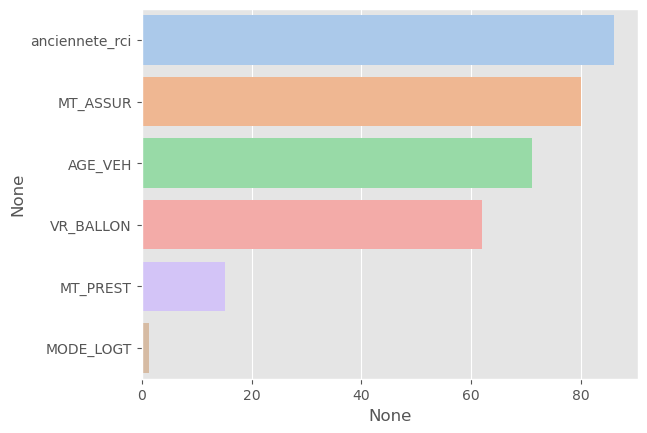

In [11]:
Taux = (df.isna().sum()*100/len(df)).sort_values(ascending=False)[:6]
with plt.style.context('ggplot') :
    sns.barplot(x=Taux,y= Taux.index,palette='pastel')

We observe that 6 variables have missing data.

Visualisons la répartition de valeurs manquantes sous forme de heatmap.

In [14]:
plt.figure()
sns.heatmap(df.isna())

<Axes: >

We replace the commas in the columns with dots to convert these columns into numbers.

In [16]:
list_coma = ["MT_ASSUR","MT_PREST","PRIX_VEH","MT_APPORT","MT_FINANCE","MT_MENS","VR_BALLON"]
for i in list_coma:
    df[i] = df[i].str.replace(',','.').astype('float')

Using the documentation on the variable balloon, we deduce the following formula:/

PRIX_VEH = (MT_MENS * DUREE_CONTRAT) + MT_APPORT + VR_BALLON donc \
PRIX_VEH - MT_APPORT - (MT_MENS*DUREE_CONTRAT) est une estimation de ballon.

In [18]:
# delete duplicates

df.drop_duplicates(keep='first',inplace=True)
df.reset_index(drop=True,inplace=True)

# imputation of the BALLOON

df['estim_ballon'] = df['PRIX_VEH'] - df['MT_APPORT'] - (df['MT_MENS']*df['DUREE_CONTRAT'])
df[df['VR_BALLON'].isna()]['estim_ballon'].max()

0.15999999999985448

The maximum estimated value of the balloon is 0.16, so all balloons are below this value. We conclude that the VR_BALLON with a value of NaN corresponds to 0.

In [20]:
# RCI nan => new client we replace RCI nan with 0
df['anciennete_rci'].fillna(0,inplace = True)

# AGE_VEH nan => new VEH we replace AGE_VEH nan with 0
df['AGE_VEH'].fillna(0,inplace = True)


# Ballon na => null balloon. We replace the balloons with 0
df['VR_BALLON'].fillna(0,inplace = True)
df.drop(['estim_ballon'],axis=1,inplace=True)
df['MT_PREST'].fillna(150,inplace = True)

df['MT_ASSUR'].fillna(0,inplace = True)

C:\Users\tomky\AppData\Local\Temp\ipykernel_15840\3821952720.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['anciennete_rci'].fillna(0,inplace = True)
C:\Users\tomky\AppData\Local\Temp\ipykernel_15840\3821952720.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [21]:
# completion mode_logt
df4 = df[['MODE_LOGT','SITUATION_FAM','age_cli','ANC_EMPLOI']]
imputer = KNNImputer(n_neighbors=1)
df4 =pd.DataFrame(imputer.fit_transform(df4),
                  columns=['MODE_LOGT','SITUATION_FAM','age_cli','ANC_EMPLOI'])
df4['MODE_LOGT'] = (df4['MODE_LOGT']+0.5).astype(int)
df['MODE_LOGT'] = df4['MODE_LOGT']

#### In summary:

anciennete_rci: Missing data corresponds to new clients. We replace NaN with 0.

MT_ASSUR: NaN => no insurance = 0.

AGE_VEH: NaN implies a new vehicle, so NaN = 0.

VR_BALLON: This variable can be obtained or at least approximated by a linear combination of the variables PRIX_VEH, DUREE_CONTRAT, MT_MENS, MT_APPORT (or pc_appo). We observe that the NaN values actually correspond to null balloon values. Therefore, we replace all NaN values in this variable with 0.

MT_PREST: The column has low variance. We replace NaN with the most frequent value (90% of the dataframe). NaN = 150.

MODE_LOGT: The number of missing values is low; we impute these with the dominant housing mode among the 5 nearest neighbors.

In [23]:
(df.isna().sum()*100/len(df)).sort_values(ascending=False)

ANC_EMPLOI        0.0
VR_BALLON         0.0
pc_appo           0.0
anciennete_rci    0.0
age_cli           0.0
mois_gestion      0.0
MT_ASSUR          0.0
MT_PREST          0.0
DUREE_CONTRAT     0.0
MT_MENS           0.0
SITUATION_FAM     0.0
MT_FINANCE        0.0
MT_APPORT         0.0
PRIX_VEH          0.0
MARQUE            0.0
VN_VO             0.0
AGE_VEH           0.0
MODE_LOGT         0.0
def12_31          0.0
dtype: float64

We no longer have any missing data.

Nous créons des ratios

In [26]:
df['ratio_MT_finance/prix'] = df['MT_FINANCE']/df['PRIX_VEH']
df['ratio_MT_MENS/prix'] = df['MT_MENS']/df['PRIX_VEH']
df['ratio_BALLON/prix'] = df['VR_BALLON']/df['PRIX_VEH']
df['ratio_MT_PREST/pri'] = df['MT_PREST']/df['PRIX_VEH']
df['ratio_DUREE_CONTRAT/prix'] = df['DUREE_CONTRAT']/df['PRIX_VEH']
df['ratio_age_cli/prix'] = df['age_cli']/df['PRIX_VEH']

## Visualisons les densités conditionnelles des variables

Le but est de maximiser la présence de défauts (ou non défaut) à partir d'un certain seuil.

In [29]:
with plt.style.context('ggplot') :
    sns.kdeplot(df, x = 'ANC_EMPLOI' ,hue='def12_31',common_norm=False)
    plt.axvline(300,0,1,color = 'black')
# 0 : <172
# 1 : >=172
df['ANC_EMPLOI'] = df['ANC_EMPLOI'].apply(lambda x: 0 if x < 300 else 1)

In [30]:
with plt.style.context('ggplot') :
    sns.kdeplot(df, x = 'SITUATION_FAM',hue='def12_31',common_norm=False)

In [31]:
with plt.style.context('ggplot') :
    sns.kdeplot(df, x ='MODE_LOGT',hue='def12_31',common_norm=False)

In [32]:
# VN = 1 VO = 0

df['VN_VO'] = df['VN_VO'].map(lambda x : 1 if x == 'VN' else 0)

with plt.style.context('ggplot') :
    sns.kdeplot(df,x='VN_VO',hue='def12_31',common_norm=False) 

In [33]:
encoder = LabelEncoder()
df['MARQUE'] = encoder.fit_transform(df['MARQUE'])

with plt.style.context('ggplot') :
    sns.kdeplot(df, x ='MARQUE',hue='def12_31',common_norm=False)

#Pour retrouver la marque
#encoder.inverse_transform(df['MARQUE'].unique())


# 0   [0-3[
# 1   [3-6[
# 2   [6-17[
# 3   [17-23[
# 4   [23-30]

df['MARQUE'] = df['MARQUE'].apply(lambda x: 0 if x<3
                                  else ( 1 if (x<6) and (x>=3)
                                        else (2 if (x<17) and (x>6)
                                              else (3 if (x<23) and (x>=17) else 4))))

In [34]:
with plt.style.context('ggplot') :
    sns.kdeplot(df, x='PRIX_VEH',hue='def12_31',common_norm=False)
    plt.axvline(13_000,0,1,color = 'black')
# 0 : 12k<
# 1 : >=12k
df['PRIX_VEH'] = df['PRIX_VEH'].apply(lambda x: 0 if x<13_000 else 1)

In [35]:
with plt.style.context('ggplot') :
    sns.kdeplot(df,x ='MT_APPORT',hue='def12_31',common_norm=False)
    plt.axvline(8_000,0,1)
# 0 < 8k
# 1 >=8k
df['MT_APPORT'] = df['MT_APPORT'].apply(lambda x: 0 if x<8_000 else 1)

In [36]:
with plt.style.context('ggplot') :
    sns.kdeplot(df,x='MT_FINANCE',hue='def12_31',common_norm=False)
    plt.axvline(21_500,0,1,color = 'black')
# 0 <12k
# 1 >=22k
df['MT_FINANCE'] = df['MT_FINANCE'].apply(lambda x: 0 if x<21_500 else 1)

In [37]:
with plt.style.context('ggplot') :
    sns.kdeplot(df,x='MT_MENS',hue='def12_31',common_norm=False)
    plt.axvline(250,0,1,color = 'black')
#0 <250
#1
#2 >435
df['MT_MENS'] = df['MT_MENS'].apply(lambda x: 0 if x<250
                                    else (1 if (x>=250) and (x<=435) else 2))

In [38]:
with plt.style.context('ggplot') :
    sns.kdeplot(df, x='VR_BALLON',hue='def12_31',common_norm=False)
    plt.axvline(12_000,0,1,color = 'black')
# 0 < 5k
# 1 >5k
df['VR_BALLON'] = df['VR_BALLON'].apply(lambda x: 0 if x<10_500 else 1)

In [39]:
with plt.style.context('ggplot') :
    sns.kdeplot(df, x='DUREE_CONTRAT',hue='def12_31',common_norm=False)
    plt.axvline(30,0,1,color = 'black')
    plt.axvline(40,0,1,color = 'black')
# 0 <30
# 1 30,40
# 2 ]40>60]


df['DUREE_CONTRAT'] = df['DUREE_CONTRAT'].apply(lambda x: 0 if x<30
                                                else (1 if (x <=40) and (x>=34) else 2))

In [40]:
df['mois_gestion'] = pd.to_datetime(df['mois_gestion'])

df['year'] = df['mois_gestion'].dt.year
df['month'] = df['mois_gestion'].dt.day #mois
df['year'] = df['year'].apply(lambda x : 0 if x == 2014 else 12)
df['mois_gestion'] = df['year'] + df ['month']
df.drop(['year','month'],axis=1,inplace=True)

with plt.style.context('ggplot') :
    sns.kdeplot(df,x='mois_gestion',hue='def12_31',common_norm=False)

In [41]:
with plt.style.context('ggplot') :
    sns.kdeplot(df,x='age_cli',hue='def12_31',common_norm=False)
    plt.axvline(36, 0,1,color='black')
# 0 <36
# 1 >=37
df['age_cli'] = df['age_cli'].apply(lambda x: 0 if x<30 else 1)

In [42]:
with plt.style.context('ggplot') :
    sns.kdeplot(df,x='pc_appo',hue='def12_31',common_norm=False)
    plt.axvline(25,0,1,color = 'black')
# 0 <25
# 1 >=25

df['pc_appo'] = df['pc_appo'].apply(lambda x: 0 if x<25 else 1)

In [43]:
with plt.style.context('ggplot') :
    sns.kdeplot(df,x='MT_PREST',hue='def12_31',common_norm=False)
    plt.axvline(130,0,1,color = 'black')
    plt.axvline(170,0,1,color = 'black')
# 0 <=130
# 1 130< <=170
# 2 >170

df['MT_PREST'] = df['MT_PREST'].apply(lambda x: 0 if x==150 else 1)

In [44]:
with plt.style.context('ggplot') :
    sns.kdeplot(df,x='MT_ASSUR',hue='def12_31',common_norm=False)
    plt.axvline(65, 0,1,color='black')
    plt.axvline(325,0,1,color = 'black')
#0 <70
#1 >=70

df['MT_ASSUR'] = df['MT_ASSUR'].apply(lambda x: 0 if x<70 else 1)

In [45]:
with plt.style.context('ggplot') :
    sns.kdeplot(df,x='AGE_VEH',hue='def12_31',common_norm=False)
    plt.axvline(7,0,1,color = 'black')
    
# 0 <7
# 1 >=7

df['AGE_VEH'] = df['AGE_VEH'].apply(lambda x: 0 if x<7 else 1)

In [46]:
with plt.style.context('ggplot') :
    sns.kdeplot(df, x = 'ratio_MT_finance/prix' ,hue='def12_31',common_norm=False)
    plt.axvline(0.75,0,1,color = 'black')
# 0 : <0.75
# 1 : >= 0.75
df['ratio_MT_finance/prix'] = df['ratio_MT_finance/prix'].apply(lambda x:
                                                                0 if x < 0.75 else 1)

In [47]:
with plt.style.context('ggplot') :
    sns.kdeplot(df, x = 'ratio_MT_MENS/prix' ,hue='def12_31',common_norm=False)
    plt.axvline(0.013,0,1,color = 'black')
    plt.axvline(0.020,0,1,color = 'black')
# 0 : <0.013
# 1 : 
# 2 : >=0.020
df['ratio_MT_MENS/prix'] = df['ratio_MT_MENS/prix'].apply(lambda x:
                                                          0 if x < 0.013
                                                          else (1 if (x>=0.013) and (x<0.02)
                                                                else 2))

In [48]:
with plt.style.context('ggplot') :
    sns.kdeplot(df, x = 'ratio_BALLON/prix' ,hue='def12_31',common_norm=False)

# 0 : <0.04
# 1 : 0.04< x < 0.3
# 2 : >0.3
df['ratio_BALLON/prix'] = df['ratio_BALLON/prix'].apply(lambda x:
                                                        0 if x < 0.04
                                                        else 1)

In [49]:
with plt.style.context('ggplot') :
    sns.kdeplot(df, x = 'ratio_MT_PREST/pri' ,hue='def12_31',common_norm=False)
    plt.axvline(0.01,0,1,color = 'black')
# 0 : <0.01
# 1 : >=200
df['ratio_MT_PREST/pri'] = df['ratio_MT_PREST/pri'].apply(lambda x: 0 if x < 0.013 else 1)

In [50]:
with plt.style.context('ggplot') :
    sns.kdeplot(df, x = 'ratio_DUREE_CONTRAT/prix' ,hue='def12_31',common_norm=False)

# 0 : <0.003
# 1 : >=
df['ratio_DUREE_CONTRAT/prix'] = df['ratio_DUREE_CONTRAT/prix'].apply(lambda x:
                                                                      0 if x < 0.003
                                                                      else 1)

In [51]:
with plt.style.context('ggplot') :
    sns.kdeplot(df, x = 'ratio_age_cli/prix' ,hue='def12_31',common_norm=False)
    plt.axvline(0.0048,0,1)
# 0 : < 0.0048
# 1 : >=
df['ratio_age_cli/prix'] = df['ratio_age_cli/prix'].apply(lambda x: 0 if x < 0.0048 else 1)

## Conditional Probabilities

In [53]:
l = [0]*(df.shape[1])

for i in range(df.shape[1]):

    a = df[df['def12_31']==0].iloc[:,[i]].value_counts(normalize=True).sort_index(ascending=True)*100
    b = df[df['def12_31']==1].iloc[:,[i]].value_counts(normalize=True).sort_index(ascending=True)*100
    c = (df.iloc[:,[i]].value_counts(normalize=True).sort_index(ascending=True))*100

    d = pd.concat([a,b,c],axis=1,keys=['0','1','Total'])
    d.fillna(0,inplace=True)
    l[i] = d.sort_values(by = ['Total'], ascending= False)

In [54]:
l[0]

,0,1,Total
ANC_EMPLOI,,,
0,82.603494,94.897959,82.745979
1,17.396506,5.102041,17.254021


In [55]:
l[1]

,0,1,Total
SITUATION_FAM,,,
1,71.368749,46.938776,71.085620
2,19.992821,43.877551,20.269631
11,3.936348,6.122449,3.961684
4,1.806652,2.040816,1.809366
5,1.447715,1.020408,1.442763
3,1.447715,0.000000,1.430937


Family situation 1 accounts for 71% of the dataset, yet only 45% default. This variable therefore has a negative impact on defaulting.\
Family situation 2, on the other hand, represents 20% of the dataset, but 45% default. This thus has a positive impact.

In [57]:
l[2]

,0,1,Total
MODE_LOGT,,,
2,76.537449,47.959184,76.206244
1,13.603733,26.530612,13.753548
4,9.081120,24.489796,9.259697
3,0.777698,1.020408,0.780511


Housing mode 2 accounts for 76% of the dataset, but only 47 default. This variable therefore has a negative impact on defaulting.

In [59]:
l[3]

,0,1,Total
AGE_VEH,,,
0,74.491505,44.897959,74.148534
1,25.508495,55.102041,25.851466


In [60]:
l[4]

,0,1,Total
VN_VO,,,
1,71.32089,41.836735,70.979186
0,28.67911,58.163265,29.020814


In [61]:
l[5]

,0,1,Total
MARQUE,,,
3,66.882029,59.183673,66.792810
1,27.398899,27.551020,27.400662
2,2.943288,8.163265,3.003784
4,2.117732,3.061224,2.128666
0,0.658052,2.040816,0.674078


In [62]:
l[6]

,0,1,Total
PRIX_VEH,,,
1,88.394353,66.326531,88.1386
0,11.605647,33.673469,11.8614


In [63]:
l[7]

,0,1,Total
MT_APPORT,,,
0,79.038047,95.918367,79.23368
1,20.961953,4.081633,20.76632


In [64]:
l[8]

,0,1,Total
MT_FINANCE,,,
0,95.561139,100.0,95.612583
1,4.438861,0.0,4.387417


In [65]:
l[9]

,0,1,Total
MT_MENS,,,
1,56.963388,53.061224,56.918165
0,38.837042,46.938776,38.930937
2,4.199569,0.000000,4.150899


In [66]:
l[10]

,0,1,Total
VR_BALLON,,,
0,90.284757,96.938776,90.361873
1,9.715243,3.061224,9.638127


In [67]:
l[11]

,0,1,Total
DUREE_CONTRAT,,,
1,52.644173,32.653061,52.412488
2,39.231874,64.285714,39.522233
0,8.123953,3.061224,8.065279


In [68]:
l[12]

,0,1,Total
MT_PREST,,,
0,94.23307,95.918367,94.252602
1,5.76693,4.081633,5.747398


In [69]:
l[13]

,0,1,Total
MT_ASSUR,,,
0,79.947356,76.530612,79.907758
1,20.052644,23.469388,20.092242


In [70]:
l[14]

,0,1,Total
mois_gestion,,,
19,9.595597,3.061224,9.519868
13,9.272553,11.224490,9.295175
14,6.724097,4.081633,6.693472
7,6.221584,9.183673,6.255913
15,5.707107,6.122449,5.711921
22,5.455851,7.142857,5.475402
16,5.372099,3.061224,5.345317
21,5.372099,3.061224,5.345317
17,4.702082,4.081633,4.694891


In [71]:
l[15]

,0,1,Total
age_cli,,,
1,91.529074,73.469388,91.319773
0,8.470926,26.530612,8.680227


In [72]:
l[16]

,0,1,Total
anciennete_rci,,,
0.0,88.155061,95.918367,88.245033
2.0,4.558507,2.040816,4.529328
1.0,4.259392,2.040816,4.233680
3.0,2.775784,0.000000,2.743614
4.0,0.251256,0.000000,0.248344


In [73]:
l[17]

,0,1,Total
pc_appo,,,
0,52.89543,77.55102,53.181173
1,47.10457,22.44898,46.818827


In [74]:
l[18]

,0,1,Total
def12_31,,,
0,100.0,0.0,98.84106
1,0.0,100.0,1.15894


In [75]:
l[19]

,0,1,Total
ratio_MT_finance/prix,,,
1,54.032065,78.571429,54.316462
0,45.967935,21.428571,45.683538


In [76]:
l[20]

,0,1,Total
ratio_MT_MENS/prix,,,
1,63.795166,74.489796,63.919111
0,28.403924,10.204082,28.192999
2,7.800909,15.306122,7.887890


In [77]:
l[21]

,0,1,Total
ratio_BALLON/prix,,,
0,61.785116,76.530612,61.956008
1,38.214884,23.469388,38.043992


In [78]:
l[22]

,0,1,Total
ratio_MT_PREST/pri,,,
0,89.124192,73.469388,88.942763
1,10.875808,26.530612,11.057237


In [79]:
l[23]

,0,1,Total
ratio_DUREE_CONTRAT/prix,,,
0,69.586025,34.693878,69.181646
1,30.413975,65.306122,30.818354


In [80]:
l[24]

,0,1,Total
ratio_age_cli/prix,,,
0,96.075616,87.755102,95.979186
1,3.924384,12.244898,4.020814


Creation of dummies and deletion of "mois_gestion"

In [82]:
df_dum = pd.get_dummies(df, columns=['ANC_EMPLOI','MODE_LOGT','SITUATION_FAM',
                                     'AGE_VEH','MARQUE','PRIX_VEH','VN_VO',
                                     'MT_APPORT','MT_FINANCE','MT_MENS','VR_BALLON',
                                     'DUREE_CONTRAT','age_cli','anciennete_rci',
                                     'pc_appo','MT_PREST','ratio_MT_finance/prix',
                                     'ratio_MT_MENS/prix','ratio_BALLON/prix',
                                     'ratio_MT_PREST/pri','ratio_DUREE_CONTRAT/prix',
                                     'ratio_age_cli/prix','MT_ASSUR'])


target = df_dum['def12_31']

df_dum = df_dum.drop(columns =['mois_gestion','def12_31'],axis=1)

## LOGISTIC REGRESSION WITH OVERSAMPLING

We perform an oversampled logistic regression on the data, remove variables with an OR too close to 1, and rerun the model with the retained columns. This process is repeated until a satisfactory number of variables is achieved.\
Here, we selected a maximum of 10 variables.\

In [85]:
#split
x_train, x_test, y_train, y_test = train_test_split(df_dum,target,test_size=0.2,stratify=target)
x_train = x_train.astype(float)
x_test = x_test.astype(float)
y_train = y_train.astype(float)
y_test = y_test.astype(float)


# ré échant
smo = SMOTE(sampling_strategy=0.3)
x_sm, y_sm = smo.fit_resample(x_train, y_train)

#modele
modele_logit_sur = LogisticRegression(penalty=None,solver='newton-cg')
modele_logit_sur.fit(x_sm,y_sm)

LogisticRegression(penalty=None, solver='newton-cg')

In [86]:
# We create a table with the ODD RATIOS as well as the coefficients.
logi = pd.DataFrame(modele_logit_sur.coef_,index = ["coef"],
                                   columns = list(x_sm.columns)).T
logi['OR'] = logi['coef'].apply(np.exp)

#cols = logi['colonne choisies']

In [87]:
logi

,coef,OR
ANC_EMPLOI_0,0.318732,1.375382
ANC_EMPLOI_1,-1.426912,0.240049
MODE_LOGT_1,-0.034109,0.966466
MODE_LOGT_2,-0.539564,0.583002
MODE_LOGT_3,-0.669165,0.512136
...,...,...
ratio_DUREE_CONTRAT/prix_1,-0.303124,0.738508
ratio_age_cli/prix_0,-1.000721,0.367614
ratio_age_cli/prix_1,-0.107460,0.898113
MT_ASSUR_0,-0.560937,0.570674


We manually examine the raw OR of each variable and remove those with an OR close to 1.\
The model is rerun, retaining variables with significant OR values.\
This process is repeated until fewer than 10 variables remain.

Below is a code snippet to automate the process described above.\
A threshold set too high will exclude relevant variables and lead to poor accuracy.\
Here, we have set the threshold to 2 (-2 < coef < 2) to reduce computation time.

start = time()
longueur = 100
seuil = 2
#cols = df_dum.columns
while longueur > 10:
    try:
        df3 = df_dum[cols]
    except:
        df3 = df_dum
    
    #split
    x_train, x_test, y_train, y_test = train_test_split(df3,target,test_size=0.2,stratify=target)
    
    # ré échant
    smo = SMOTE(sampling_strategy=0.3)
    x_sm, y_sm = smo.fit_resample(x_train, y_train)
    #modele
    modele_logit_sur = LogisticRegression(penalty=None,solver='newton-cg')
    modele_logit_sur.fit(x_sm,y_sm)
    
    logi = pd.DataFrame(np.concatenate([modele_logit_sur.intercept_.reshape(-1,1),
                             modele_logit_sur.coef_],axis=1),
             index = ["coef"],columns = ["constante"]+list(x_sm.columns)).T

    logi.reset_index(inplace=True)
    logi = logi.drop(logi[logi['index']=='constante'].index,axis=0)
    logi['OR'] = logi['coef'].apply(np.exp)
    logi = logi[(logi['coef']<-seuil) | (logi['coef']>+seuil)]
    cols = logi['index'].unique()
    if longueur != len(logi):
        longueur = len(logi)
        #print('longueur =',longueur)
    
print('Durée : ',time()-start)
logi

In [91]:
print('Number of defaults per 5% interval for the oversampled logit.')

a = pd.DataFrame(y_test).reset_index(drop=True)
b = pd.DataFrame(modele_logit_sur.predict_proba(x_test)[::,1],columns=['proba']).reset_index(drop=True)
d = pd.concat([a,b],axis=1)
d.sort_values(by='proba',ascending=False,inplace=True)
c = pd.DataFrame(list(range(len(y_test))),columns=['pourcent'])
c = pd.cut(c['pourcent'],bins=20,labels=range(5,101,5))
d = d.reset_index(drop=True)
d = pd.concat([d,c],axis=1)
d = d.groupby('pourcent')['def12_31'].sum()
d

Number of defaults per 5% interval for the oversampled logit.


C:\Users\tomky\AppData\Local\Temp\ipykernel_15840\708660779.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d.groupby('pourcent')['def12_31'].sum()


pourcent
5      5.0
10     1.0
15     1.0
20     1.0
25     2.0
30     0.0
35     1.0
40     0.0
45     1.0
50     1.0
55     2.0
60     0.0
65     2.0
70     0.0
75     0.0
80     0.0
85     0.0
90     2.0
95     1.0
100    0.0
Name: def12_31, dtype: float64

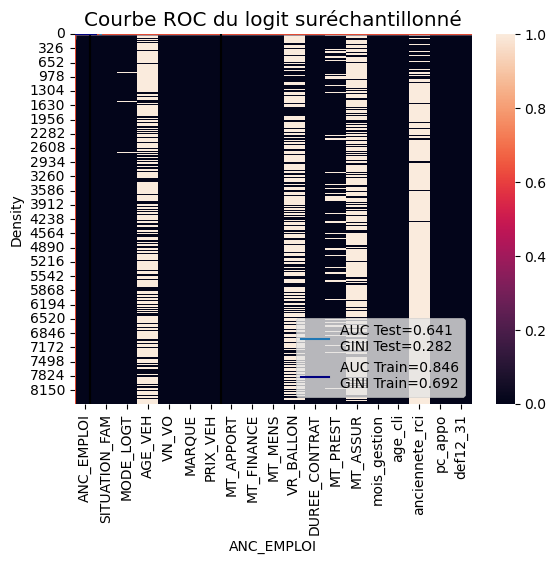

In [92]:
with plt.style.context('ggplot') :
    y_pred_proba = modele_logit_sur.predict_proba(x_test)[::,1]
    y_train_pred_proba = modele_logit_sur.predict_proba(x_sm)[::,1]    
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    
    
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = metrics.roc_curve(y_test, random_probs, pos_label=1)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    auc2 = metrics.roc_auc_score(y_test, random_probs)
    
    fpr3,tpr3, _ = metrics.roc_curve(y_sm,y_train_pred_proba)
    auc3 = metrics.roc_auc_score(y_sm,y_train_pred_proba)
    #create ROC curve
    plt.plot(fpr,tpr,label="AUC Test="+str(round(auc,3))+'\nGINI Test='+str(round(2*auc-1,3)))
    plt.plot(p_fpr, p_tpr, color='black')
    plt.plot(fpr3, tpr3, color='navy',label='AUC Train='+str(round(auc3,3))+'\nGINI Train='+str(round(2*auc3-1,3)))

    plt.title('Courbe ROC du logit suréchantillonné')
    plt.legend(loc=4)
    plt.show()

## LOGISTIC REGRESSION WITHOUT RESAMPLING

We perform an oversampled logistic regression on the data, remove variables with an OR too close to 1, and rerun the model with the retained columns.\
This process is repeated until a satisfactory number of variables is achieved.\
Here, we selected a maximum of 10 variables.

In [95]:
#split
x_train, x_test, y_train, y_test = train_test_split(df_dum,target,test_size=0.2,stratify=target)

#modele
modele_logit = LogisticRegression(penalty=None,solver='newton-cg')
modele_logit.fit(x_train,y_train)

LogisticRegression(penalty=None, solver='newton-cg')

In [96]:
logi = pd.DataFrame(modele_logit.coef_,index = ["coef"],
                                   columns = list(x_train.columns)).T
logi['OR'] = logi['coef'].apply(np.exp)
#col2 = logi['colonnes choisies']

In [97]:
logi

,coef,OR
ANC_EMPLOI_0,0.016433,1.016569
ANC_EMPLOI_1,-0.820431,0.440242
MODE_LOGT_1,0.741634,2.099363
MODE_LOGT_2,0.178966,1.195980
MODE_LOGT_3,-2.247897,0.105621
...,...,...
ratio_DUREE_CONTRAT/prix_1,-0.028009,0.972380
ratio_age_cli/prix_0,-0.710693,0.491304
ratio_age_cli/prix_1,-0.093305,0.910916
MT_ASSUR_0,-0.546990,0.578689


As with the oversampled logit, below is a code snippet to automate the column selection process.\
The threshold is still set to 2 to reduce computation time.\

start = time()
longueur = 100
seuil = 2
#col2 = df_dum.columns
while longueur > 10:
    try:
        df3 = df_dum[col2]
    except:
        df3 = df_dum
    
    #split
    x_train, x_test, y_train, y_test = train_test_split(df3,target,test_size=0.2,stratify=target)
    
    #modele
    modele_logit = LogisticRegression(penalty=None,solver='newton-cg')
    modele_logit.fit(x_train,y_train)

    logi = pd.DataFrame(np.concatenate([modele_logit.intercept_.reshape(-1,1),
                             modele_logit.coef_],axis=1),
             index = ["coef"],columns = ["constante"]+list(x_train.columns)).T

    logi.reset_index(inplace=True)
    logi = logi.drop(logi[logi['index']=='constante'].index,axis=0)
    logi['OR'] = logi['coef'].apply(np.exp)
    logi = logi[(logi['coef']<-seuil) | (logi['coef']>+seuil)]
    col2 = logi['index'].unique()
    if longueur != len(logi):
        longueur = len(logi)
        print('longueur =',longueur)
    
print('Durée : ',time()-start)
logi

In [100]:
print('Number of defaults per 5% interval for the logit without resampling.')
a = pd.DataFrame(y_test).reset_index(drop=True)
b = pd.DataFrame(modele_logit.predict_proba(x_test)[::,1],columns=['proba']).reset_index(drop=True)
d = pd.concat([a,b],axis=1)
d.sort_values(by='proba',ascending=False,inplace=True)
c = pd.DataFrame(list(range(len(y_test))),columns=['pourcent'])
c = pd.cut(c['pourcent'],bins=20,labels=range(5,101,5))
d = d.reset_index(drop=True)
d = pd.concat([d,c],axis=1)
d = d.groupby('pourcent')['def12_31'].sum()
d

Number of defaults per 5% interval for the logit without resampling.


C:\Users\tomky\AppData\Local\Temp\ipykernel_15840\673590413.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d.groupby('pourcent')['def12_31'].sum()


pourcent
5      4
10     5
15     1
20     0
25     3
30     0
35     1
40     0
45     0
50     2
55     0
60     1
65     1
70     0
75     1
80     0
85     1
90     0
95     0
100    0
Name: def12_31, dtype: int64

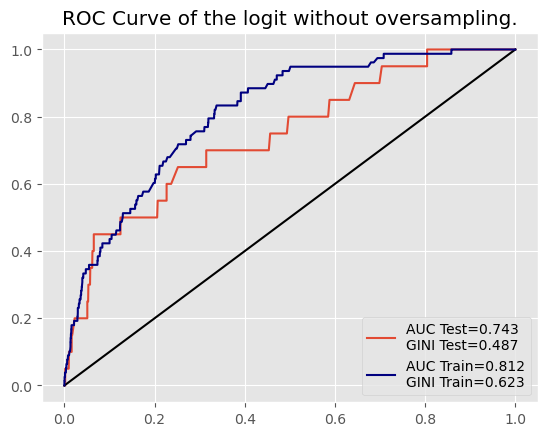

In [101]:
with plt.style.context('ggplot') :
    y_pred_proba = modele_logit.predict_proba(x_test)[::,1]
    y_train_pred_proba = modele_logit.predict_proba(x_train)[::,1]    
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    
    
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = metrics.roc_curve(y_test, random_probs, pos_label=1)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    auc2 = metrics.roc_auc_score(y_test, random_probs)
    
    fpr3,tpr3, _ = metrics.roc_curve(y_train,y_train_pred_proba)
    auc3 = metrics.roc_auc_score(y_train,y_train_pred_proba)
    #create ROC curve
    plt.plot(fpr,tpr,label="AUC Test="+str(round(auc,3))+'\nGINI Test='+str(round(2*auc-1,3)))
    plt.plot(p_fpr, p_tpr, color='black')
    plt.plot(fpr3, tpr3, color='navy',label='AUC Train='+str(round(auc3,3))+'\nGINI Train='+str(round(2*auc3-1,3)))

    plt.title('ROC Curve of the logit without oversampling.')
    plt.legend(loc=4)
    plt.show()

## Modèle Random Forest

In [103]:
x_train, x_test, y_train, y_test = train_test_split(df_dum,
                                                    target,test_size=0.2,stratify=target)
x_train = x_train.astype(float)
x_test = x_test.astype(float)
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# RF
modele_rf=RandomForestClassifier()
modele_rf.fit(x_train,y_train)
y_rf_predict = modele_rf.predict(x_test)
y_rf_proba = modele_rf.predict_proba(x_test)[::,1]
y_rf_train_proba = modele_rf.predict_proba(x_train)[::,1]

# RF with oversampling
smo = SMOTE(sampling_strategy=0.3)
x_sm, y_sm = smo.fit_resample(x_train, y_train)
modele_rf_sm=RandomForestClassifier()
modele_rf_sm.fit(x_sm,y_sm)
y_rf_sm_predict = modele_rf_sm.predict(x_test)
y_rf_sm_proba = modele_rf_sm.predict_proba(x_test)[::,1]
y_rf_sm_train_proba = modele_rf_sm.predict_proba(x_sm)[::,1]

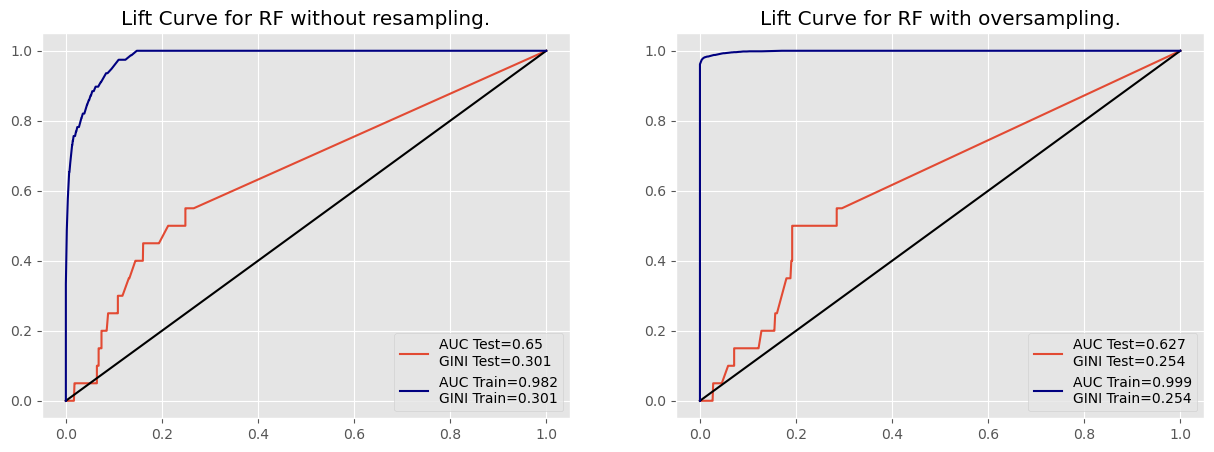

In [104]:
with plt.style.context('ggplot') :
    
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,2,1)
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_rf_proba)
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = metrics.roc_curve(y_test, random_probs, pos_label=1)
    auc = metrics.roc_auc_score(y_test, y_rf_proba)
    auc2 = metrics.roc_auc_score(y_test, random_probs)
    fpr3,tpr3, _ = metrics.roc_curve(y_train,y_rf_train_proba)
    auc3 = metrics.roc_auc_score(y_train,y_rf_train_proba)
    #create ROC curve
    plt.plot(fpr,tpr,label="AUC Test="+str(round(auc,3))+'\nGINI Test='+str(round(2*auc-1,3)))
    plt.plot(p_fpr, p_tpr, color='black')
    plt.plot(fpr3, tpr3, color='navy',label='AUC Train='+str(round(auc3,3))+'\nGINI Train='+str(round(2*auc-1,3)))
    plt.legend(loc=4)
    plt.title('Lift Curve for RF without resampling.')
    
    plt.subplot(1,2,2)
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_rf_sm_proba)
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = metrics.roc_curve(y_test, random_probs, pos_label=1)
    auc = metrics.roc_auc_score(y_test, y_rf_sm_proba)
    auc2 = metrics.roc_auc_score(y_test, random_probs)
    fpr3,tpr3, _ = metrics.roc_curve(y_sm,y_rf_sm_train_proba)
    auc3 = metrics.roc_auc_score(y_sm,y_rf_sm_train_proba)
    #create ROC curve
    plt.plot(fpr,tpr,label="AUC Test="+str(round(auc,3))+'\nGINI Test='+str(round(2*auc-1,3)))
    plt.plot(p_fpr, p_tpr, color='black')
    plt.plot(fpr3, tpr3, color='navy',label='AUC Train='+str(round(auc3,3))+'\nGINI Train='+str(round(2*auc-1,3)))
    plt.legend(loc=4)
    plt.title('Lift Curve for RF with oversampling.')
    plt.show()

In [105]:
print('Number of defaults per 5% interval for the random forest model without resampling.')

a = pd.DataFrame(y_test).reset_index(drop=True)
b = pd.DataFrame(y_rf_proba,columns=['proba']).reset_index(drop=True)
d = pd.concat([a,b],axis=1)
d.sort_values(by='proba',ascending=False,inplace=True)
c = pd.DataFrame(list(range(len(y_test))),columns=['pourcent'])
c = pd.cut(c['pourcent'],bins=20,labels=range(5,101,5))
d = d.reset_index(drop=True)
d = pd.concat([d,c],axis=1)
d = d.groupby('pourcent')['def12_31'].sum()
d

Number of defaults per 5% interval for the random forest model without resampling.


C:\Users\tomky\AppData\Local\Temp\ipykernel_15840\222463375.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d.groupby('pourcent')['def12_31'].sum()


pourcent
5      1.0
10     4.0
15     3.0
20     1.0
25     1.0
30     1.0
35     0.0
40     1.0
45     0.0
50     1.0
55     0.0
60     0.0
65     1.0
70     2.0
75     2.0
80     0.0
85     0.0
90     1.0
95     0.0
100    1.0
Name: def12_31, dtype: float64

In [106]:
print('Number of defaults per 5% interval for the oversampled random forest model.')

a = pd.DataFrame(y_test).reset_index(drop=True)
b = pd.DataFrame(y_rf_sm_proba,columns=['proba']).reset_index(drop=True)
d = pd.concat([a,b],axis=1)
d.sort_values(by='proba',ascending=False,inplace=True)
c = pd.DataFrame(list(range(len(y_test))),columns=['pourcent'])
c = pd.cut(c['pourcent'],bins=20,labels=range(5,101,5))
d = d.reset_index(drop=True)
d = pd.concat([d,c],axis=1)
d = d.groupby('pourcent')['def12_31'].sum()
d

Number of defaults per 5% interval for the oversampled random forest model.


C:\Users\tomky\AppData\Local\Temp\ipykernel_15840\295328148.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d.groupby('pourcent')['def12_31'].sum()


pourcent
5      1.0
10     2.0
15     1.0
20     6.0
25     0.0
30     1.0
35     1.0
40     0.0
45     1.0
50     1.0
55     0.0
60     0.0
65     1.0
70     1.0
75     1.0
80     1.0
85     0.0
90     1.0
95     0.0
100    1.0
Name: def12_31, dtype: float64

# Neural network

In [108]:
device="gpu" if torch.cuda.is_available() else "cpu"

class BinaryClassification(pl.LightningModule):
    def __init__(self, input_features):
        super(BinaryClassification, self).__init__()
        self.fc1 = nn.Linear(input_features, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)
        self.criterion = nn.BCELoss()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x).squeeze()
        loss = self.criterion(outputs, y)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=0.1)

In [109]:
x_train, x_test, y_train, y_test = train_test_split(df_dum.values, target,test_size=0.2,stratify=target)
x_train = x_train.astype(float)
x_test = x_test.astype(float)
y_train = y_train.astype(float)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)

In [110]:
dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [111]:
# Train using PyTorch Lightning
model = BinaryClassification(df_dum.shape[1])
trainer = pl.Trainer(max_epochs=100, accelerator=device)
trainer.fit(model, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\tomky\AppData\Local\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | fc1       | Linear  | 6.2 K  | train
1 | fc2       | Linear  | 10.1 K | train
2 | fc3       | Linear  | 101    | train
3 | criterion | BCELoss | 0      | train
----------------------------------------------
16.4 K    Trainable params
0         Non-trainab

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [112]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(x_test).squeeze()
    predictions = (predictions >= 0.5).int()  # Convert probabilities to binary predictions
    accuracy = (predictions == torch.tensor(y_test.values)).sum().item() / len(y_test)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 98.76%


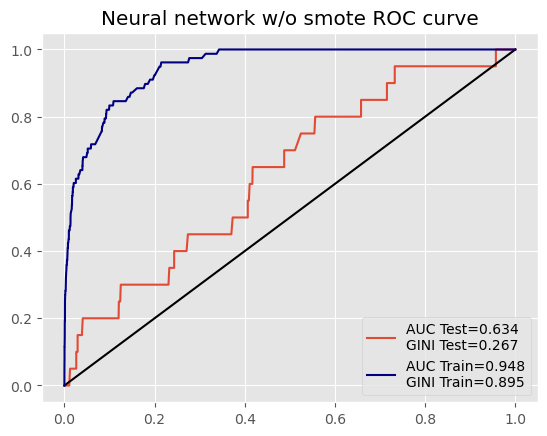

In [113]:
with plt.style.context('ggplot') :
    y_pred_proba = model(x_test).detach().numpy()
    y_train_pred_proba = model(x_train).detach().numpy()   
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    
    
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = metrics.roc_curve(y_test, random_probs, pos_label=1)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    auc2 = metrics.roc_auc_score(y_test, random_probs)
    
    fpr3,tpr3, _ = metrics.roc_curve(y_train,y_train_pred_proba)
    auc3 = metrics.roc_auc_score(y_train,y_train_pred_proba)
    #create ROC curve
    plt.plot(fpr,tpr,label="AUC Test="+str(round(auc,3))+'\nGINI Test='+str(round(2*auc-1,3)))
    plt.plot(p_fpr, p_tpr, color='black')
    plt.plot(fpr3, tpr3, color='navy',label='AUC Train='+str(round(auc3,3))+'\nGINI Train='+str(round(2*auc3-1,3)))

    plt.title('Neural network w/o smote ROC curve')
    plt.legend(loc=4)
    plt.show()

In [114]:
print('Number of defaults per 5% interval for the NN model.')

a = pd.DataFrame(y_test).reset_index(drop=True)
b = pd.DataFrame(y_pred_proba,columns=['proba']).reset_index(drop=True)
d = pd.concat([a,b],axis=1)
d.sort_values(by='proba',ascending=False,inplace=True)
c = pd.DataFrame(list(range(len(y_test))),columns=['pourcent'])
c = pd.cut(c['pourcent'],bins=20,labels=range(5,101,5))
d = d.reset_index(drop=True)
d = pd.concat([d,c],axis=1)
d = d.groupby('pourcent')['def12_31'].sum()
d

Number of defaults per 5% interval for the NN model.


C:\Users\tomky\AppData\Local\Temp\ipykernel_15840\4179579593.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d.groupby('pourcent')['def12_31'].sum()


pourcent
5      4
10     0
15     2
20     0
25     2
30     1
35     0
40     1
45     3
50     1
55     1
60     1
65     0
70     1
75     2
80     0
85     0
90     0
95     0
100    1
Name: def12_31, dtype: int64

These performances could be improved by developing a deeper model or one with more training episodes.\
Since the explainability of the results is important in our situation, we prefer to focus on another model.

# Optimisation

Optimization involves testing various parameter combinations to identify the one that maximizes the chosen metric.\
Here, we will vary the tree depth, the number of trees, the number of features, the sampling method (partition or entire dataset), the minimum number of leaves before splitting, and the minimum number of values per leaf.\
The metric used is 'recall', which corresponds to tp/(tp+fn).

## Optimization of RF without resampling.

In [119]:
x_train, x_test, y_train, y_test = train_test_split(df_dum,target,test_size=0.2,stratify=target)
x_train = x_train.astype(float)
x_test = x_test.astype(float)
y_train = y_train.astype(float)
y_test = y_test.astype(float)

start = time()

dico_param= {"max_depth":[None],
             "n_estimators":[800,1_000,1_200],\
             'max_features':['sqrt','log2'],'bootstrap' : [True, False],\
             'min_samples_split':[2,5], 'min_samples_leaf':[2,3,5]}

# we place the result of our optimization here  
# to avoid running the code unnecessarily  

dico_param= {"max_depth":[None],
             "n_estimators":[800],\
             'max_features':['sqrt'],'bootstrap' : [True],\
             'min_samples_split':[2], 'min_samples_leaf':[2]}

recherche_hyper_rf = GridSearchCV(RandomForestClassifier(),dico_param, 
                               scoring="recall",cv=5)
recherche_hyper_rf.fit(x_train, y_train)
print(time()-start)

13.47940468788147


In [120]:
recherche_hyper_rf.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 800}

In [121]:
print('Important variable for the RF model without resampling. \n')
pd.DataFrame({'variable' : df_dum.columns,
              'coef':recherche_hyper_rf.best_estimator_.feature_importances_})\
                .sort_values(by = 'coef',ascending=False).head(10)

Important variable for the RF model without resampling. 



,variable,coef
7,SITUATION_FAM_2,0.044525
2,MODE_LOGT_1,0.042912
17,MARQUE_3,0.036652
6,SITUATION_FAM_1,0.034717
35,age_cli_0,0.031383
5,MODE_LOGT_4,0.031108
36,age_cli_1,0.030174
3,MODE_LOGT_2,0.029617
60,MT_ASSUR_1,0.029178
16,MARQUE_2,0.029028


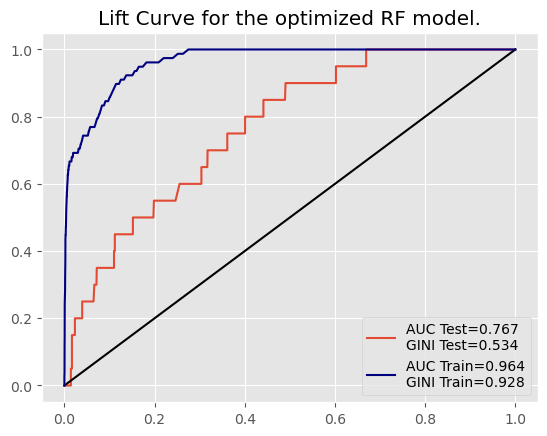

In [122]:
grid_rf_proba = recherche_hyper_rf.predict_proba(x_test)[::,1]
grid_rf_train_proba = recherche_hyper_rf.predict_proba(x_train)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test, grid_rf_proba)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = metrics.roc_curve(y_test, random_probs, pos_label=1)
auc = metrics.roc_auc_score(y_test, grid_rf_proba)
auc2 = metrics.roc_auc_score(y_test, random_probs)
fpr3,tpr3, _ = metrics.roc_curve(y_train,grid_rf_train_proba)
auc3 = metrics.roc_auc_score(y_train,grid_rf_train_proba)
#create ROC curve

with plt.style.context('ggplot') :

    plt.plot(fpr,tpr,label="AUC Test="+str(round(auc,3))+'\nGINI Test='+str(round(2*auc-1,3)))
    plt.plot(p_fpr, p_tpr, color='black')
    plt.plot(fpr3, tpr3, color='navy',label='AUC Train='+str(round(auc3,3))+'\nGINI Train='+str(round(2*auc3-1,3)))
    plt.legend(loc=4)
    plt.title('Lift Curve for the optimized RF model.')
    plt.show()

In [123]:
print('Number of defaults per 5% interval (on the test set) for the optimized random forest model without resampling.')
a = pd.DataFrame(y_test).reset_index(drop=True)
b = pd.DataFrame(grid_rf_proba,columns=['proba']).reset_index(drop=True)
d = pd.concat([a,b],axis=1)
d.sort_values(by='proba',ascending=False,inplace=True)
c = pd.DataFrame(list(range(len(y_test))),columns=['pourcent'])
c = pd.cut(c['pourcent'],bins=20,labels=range(5,101,5))
d = d.reset_index(drop=True)
d = pd.concat([d,c],axis=1)
d = d.groupby('pourcent')['def12_31'].sum()
d

Number of defaults per 5% interval (on the test set) for the optimized random forest model without resampling.


C:\Users\tomky\AppData\Local\Temp\ipykernel_15840\2495641475.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d.groupby('pourcent')['def12_31'].sum()


pourcent
5      5.0
10     2.0
15     2.0
20     1.0
25     1.0
30     1.0
35     2.0
40     1.0
45     2.0
50     1.0
55     0.0
60     0.0
65     1.0
70     1.0
75     0.0
80     0.0
85     0.0
90     0.0
95     0.0
100    0.0
Name: def12_31, dtype: float64

## Optimization of RF with Oversampling

In [125]:
x_train, x_test, y_train, y_test = train_test_split(df_dum,target,test_size=0.2,stratify=target)
x_train = x_train.astype(float)
x_test = x_test.astype(float)
y_train = y_train.astype(float)
y_test = y_test.astype(float)

start = time()

dico_param= {"max_depth":[None],
             "n_estimators":[800,1_000,1_200],\
             'max_features':['sqrt','log2'],'bootstrap' : [True, False],\
             'min_samples_split':[2,5,10], 'min_samples_leaf':[2,3,5]}

# we place the result of our optimization here  
# to avoid running the code unnecessarily

dico_param= {"max_depth":[None],
             "n_estimators":[1000],\
             'max_features':['sqrt'],'bootstrap' : [False],\
             'min_samples_split':[5], 'min_samples_leaf':[2]}

recherche_hyper_rf_sur = GridSearchCV(RandomForestClassifier(),dico_param, 
                               scoring="recall",cv=5)

smo = SMOTE(sampling_strategy=0.3)
x_sm, y_sm = smo.fit_resample(x_train, y_train)
recherche_hyper_rf_sur.fit(x_sm, y_sm)
print(time()-start)

30.834301471710205


In [126]:
recherche_hyper_rf_sur.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 1000}

In [127]:
print('Important variable for the oversampled RF model. \n')
pd.DataFrame({'variable' : df_dum.columns,
              'coef':recherche_hyper_rf_sur.best_estimator_.feature_importances_})\
                .sort_values(by = 'coef',ascending=False).head(10)

Important variable for the oversampled RF model. 



,variable,coef
3,MODE_LOGT_2,0.059980
17,MARQUE_3,0.050258
56,ratio_DUREE_CONTRAT/prix_1,0.047095
55,ratio_DUREE_CONTRAT/prix_0,0.046538
6,SITUATION_FAM_1,0.040698
59,MT_ASSUR_0,0.038620
60,MT_ASSUR_1,0.037865
2,MODE_LOGT_1,0.037042
49,ratio_MT_MENS/prix_1,0.033368
7,SITUATION_FAM_2,0.033051


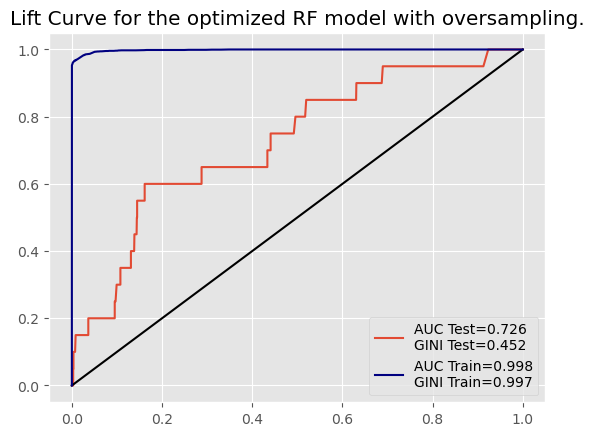

In [128]:
grid_rf_sur_proba = recherche_hyper_rf_sur.predict_proba(x_test)[::,1]
grid_rf_sur_train_proba = recherche_hyper_rf_sur.predict_proba(x_sm)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test, grid_rf_sur_proba)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = metrics.roc_curve(y_test, random_probs, pos_label=1)
auc = metrics.roc_auc_score(y_test, grid_rf_sur_proba)
auc2 = metrics.roc_auc_score(y_test, random_probs)
fpr3,tpr3, _ = metrics.roc_curve(y_sm,grid_rf_sur_train_proba)
auc3 = metrics.roc_auc_score(y_sm,grid_rf_sur_train_proba)
#create ROC curve

with plt.style.context('ggplot') :

    plt.plot(fpr,tpr,label="AUC Test="+str(round(auc,3))+'\nGINI Test='+str(round(2*auc-1,3)))
    plt.plot(p_fpr, p_tpr, color='black')
    plt.plot(fpr3, tpr3, color='navy',label='AUC Train='+str(round(auc3,3))+'\nGINI Train='+str(round(2*auc3-1,3)))
    plt.legend(loc=4)
    plt.title('Lift Curve for the optimized RF model with oversampling.')
    plt.show()

In [129]:
print('Number of defaults per 5% interval (on the test set) for the optimized random forest model with oversampling.')
a = pd.DataFrame(y_test).reset_index(drop=True)
b = pd.DataFrame(grid_rf_sur_proba,columns=['proba']).reset_index(drop=True)
d = pd.concat([a,b],axis=1)
d.sort_values(by='proba',ascending=False,inplace=True)
c = pd.DataFrame(list(range(len(y_test))),columns=['pourcent'])
c = pd.cut(c['pourcent'],bins=20,labels=range(5,101,5))
d = d.reset_index(drop=True)
d = pd.concat([d,c],axis=1)
d = d.groupby('pourcent')['def12_31'].sum()
d

Number of defaults per 5% interval (on the test set) for the optimized random forest model with oversampling.


C:\Users\tomky\AppData\Local\Temp\ipykernel_15840\1690644364.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d.groupby('pourcent')['def12_31'].sum()


pourcent
5      4.0
10     2.0
15     5.0
20     1.0
25     0.0
30     1.0
35     0.0
40     0.0
45     2.0
50     1.0
55     1.0
60     0.0
65     1.0
70     1.0
75     0.0
80     0.0
85     0.0
90     0.0
95     1.0
100    0.0
Name: def12_31, dtype: float64

## Customer Ranking

The final step is to compute \( 1 - \text{probability} \) to obtain the credit granting score for our customers, and then sort the customers in descending order based on this score.

In [131]:
cli = x_test
cli.insert(0,'score', 1 - grid_rf_proba)
cli.sort_values(by='score',ascending=False)

,score,ANC_EMPLOI_0,ANC_EMPLOI_1,MODE_LOGT_1,MODE_LOGT_2,MODE_LOGT_3,MODE_LOGT_4,SITUATION_FAM_1,SITUATION_FAM_2,SITUATION_FAM_3,...,ratio_BALLON/prix_0,ratio_BALLON/prix_1,ratio_MT_PREST/pri_0,ratio_MT_PREST/pri_1,ratio_DUREE_CONTRAT/prix_0,ratio_DUREE_CONTRAT/prix_1,ratio_age_cli/prix_0,ratio_age_cli/prix_1,MT_ASSUR_0,MT_ASSUR_1
3075,1.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5980,1.000000,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
7890,1.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
7927,1.000000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
5621,1.000000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7665,0.804849,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4508,0.792707,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
6669,0.744263,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4451,0.730213,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
